# Classification with neural networks / ニューラルネットワークによる分類 (2)

First run the code from the previous session.
<br>
まず、前のセッションのコードを実行します。

Import the needed packages.
<br>
必要なパッケージをインポートします。

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

Load the MNIST dataset.
<br>
MNISTデータセットをロードします。

In [2]:
from mnist_loader import MNISTVectorLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mnist_vector_loader = MNISTVectorLoader(43)
# X, y = mnist_vector_loader.samples(70000)
X, y = mnist_vector_loader.samples(70)

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.5)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

11493376/11490434 [==============================] - 1s 0us/step


Create the network.
<br>
ネットワークを作成します。

In [3]:
input_shape = X_train[0].shape
vector_input = Input(shape = input_shape, name='input')

fc1 = Dense(128, activation='relu', name='fc1')(vector_input)
fc2 = Dense(128, activation='relu', name='fc2')(fc1)
output = Dense(10, activation='softmax', name='output')(fc2)

network = Model(vector_input, output, name='classification')

network.summary()

Model: "classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               100480    
_________________________________________________________________
fc2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


### Training the network / ネットワークの訓練

The MNIST labels are digits:

MNISTのラベルは数字です。

In [4]:
print(y_train[:10])

[6 0 7 2 7 8 0 6 4 9]


Before using our dataset, we have to transform the label so that `keras` can compare them to the output of `output`.
The cost function has to compare the label to the outputs of the softmax function in `output`, which is a vector of size `10`.
<br>
Consequently we need to perform a __"one-hot" encoding__ of the labels in order to transform a label in a vector of size `10`.

The one-hot encoding is a vector having a length equal to the number of classes; here `10`.
<br>
The elements of the vector are set to `0` except for the position corresponding to the encoded class that is set to `1`.
<br>
For example for the digit is `5` the one-hot encoding is `[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]`

During training, the one-hot encoding of the digit is the compared to the output of the network.


データセットを使う前に、 `keras`がそれらを` output`の出力と比較できるようにラベルを変換する必要があります。
コスト関数はサイズが10のベクトルである`output`の中のsoftmax関数の出力とラベルを比較しなければなりません。
<br>
そのため、ラベルを10の大きさのベクトルに変換する必要があります。ラベルをベクトルに変更するには__one-hot(ワンホット)エンコーディング__を使用します。

ワンホットエンコーディングは、クラス数に等しい長さを持つベクトルです。
<br>
ベクトルの要素は、対象クラスに対応する要素のみが`1`に設定され、残りは`0`に設定される。
<br>
例えば、数字が`5`の場合、ワンホットエンコーディングは`[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]`です。

トレーニング中、数字のワンホットエンコーディングはネットワークの出力と比較されます。

The function `to_categorical` from `keras.utils` does this encoding:

ワンホットエンコーディングを行うためには`keras.utils`の`to_categorical`関数が使えます。

In [5]:
y_train_one_hot = to_categorical(y_train)

Let us look at a few labels:

得られたラベルをいくつか見てみましょう。

In [6]:
for i in range(10):
    print("Original digit label:", y_train[i], "Created one-hot vector label:", y_train_one_hot[i, :])

Original digit label: 6 Created one-hot vector label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Original digit label: 0 Created one-hot vector label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original digit label: 7 Created one-hot vector label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original digit label: 2 Created one-hot vector label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Original digit label: 7 Created one-hot vector label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original digit label: 8 Created one-hot vector label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Original digit label: 0 Created one-hot vector label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original digit label: 6 Created one-hot vector label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Original digit label: 4 Created one-hot vector label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original digit label: 9 Created one-hot vector label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Now that the labels are in the right format, let us prepare the training.

ラベルが正しい形式になったので、トレーニングの準備に移ります。

#### Defining the algorithm for training / トレーニング用アルゴリズムの定義

The `keras` library contains many algorithms for training neural networks.
<br>
These algorithms are __optimization algorithms__ that _adjust the trainable parameters of a model in order to minimize a loss function_.

In the case of classification, while training the network with known examples from the training set, the __cost function__ measures how "close" is the predicted output of the network to the true value.
<br>
Then, the optimizer updates the trainable weights in order to make the predicted output a "bit closer" to the true value.

`keras`ライブラリはニューラルネットワークを訓練するための多くのアルゴリズムを持っています。
<br>
これらのアルゴリズムは __最適化アルゴリズム__ です。モデルの _トレーニング可能なパラメータを調整し損失関数を最小化_ します。

分類の場合、トレーニングセットのサンプルを用いてネットワークを訓練している間、__コスト関数__ はネットワークの出力が真の値にどれだけ「近い」かを測定する。
<br>
最適化アルゴリズムは予測出力を真の値に「少し近づける」ようにネットワークの重みを更新します。

In `keras`, to use an optimizer, it is necessary to:
- define the loss function, also called `loss`
- choose the optimizer
- select performance metrics

This is done by calling the `compile` method of the `Model` object:

`keras`では、オプティマイザを使うためには、次のことが必要です。
 - 損失関数（`loss`）を定義する
 - オプティマイザを選択
 - パフォーマンス指標を選択
 
これは`Model`オブジェクトの` compile`メソッドを呼び出すことによって行われます。

In [7]:
network.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['acc'])

The parameters we used here are very typical. In most cases this will work well for classification using typical neural networks.

- The __categorical crossentropy__ loss function (`categorical_crossentropy`) is the basic choice for classification with multiple classes.
- The optimizer is of type `Adam`, and the parameter `lr` controls how "fast" the weights are modified. (`keras` provides several different optimizers but we will not explain them here in detail. `Adam` usually performs well.)
- The perfromance petrics that we are trying to optimize is accuracy (`acc`).

ここに使用したパラメータはかなり典型的なものです。ほとんどの場合、一般的なニューラルネットワークを使用した分類にこのパラメータが適しています。

- 複数のクラスでの分類には一般 __多クラス交差エントロピー__ `categorical_crossentropy`損失関数を使います。
- オプティマイザは`Adam`型で、パラメータ`lr`は重みがどのくらい速く変更されるかを制御します。（`keras`は複数のオプティマイザを提供します。ここではオプティマイザについて詳細に説明しません。`Adam`は通常、うまく機能します。）
- 最適化しようとしているパフォーマンス指標は精度（`acc`）です。

After compiling, the model is ready for training.

これでトレーニングの準備ができています。

#### The network training / ネットワークのトレーニング

The `Model` object provides the `fit` method to handle the training.
<br>
A basic use of `fit` takes the following parameters:
- a set of features: `X_train`
- the corresponding labels: `y_train_one_hot` 
- a batch size: `batch_size`
- a number of epochs: `epochs`
- a validation set: `validation_data` 

`Model`オブジェクトはトレーニングを行う` fit`メソッドを提供します。
<br>
`fit`の基本的な使い方には以下のパラメータが必要です：
 - 入力データ（特徴）： `X_train`
 - 対応するラベル： `y_train_one_hot`
 - バッチの大きさ： `batch_size`
 - エポックの数： `epochs`
 - 検証（テスト）データセット： `validation_data`

`batch_size` and `epochs` control how the optimizer handles the samples:
- The batch size defines the number of consecutive samples that are used to estimate the cost function and update the weights.
- The optimizer has performed one epoch when it has processed all the samples (it went hrough the dataset one time).

For example, if the training set has 35000 samples, the batch size is 100 and `epochs` is set to 20, then the optimizer goes throught the whole `35000` samples `20` times and each time updates the weights `350` times using loss values computed from batches of `100` samples.

`batch_size`と` epochs`はオプティマイザがサンプルをどのように扱うかを制御します。
 - バッチサイズは、コスト関数の推定と重みの更新に使用される連続サンプル数を定義します。
 - １エポックというのは、オプティマイザがすべてのサンプルの処理を1回実行しました（データセットを1回通過しました）。

例えば、トレーニングセットが35000サンプルを有する場合、バッチサイズは100であり、`epochs`は20に設定されたにしましょう。オプティマイザは35000サンプル全体を20回通過します。それぞれのエポックに350回重みを更新します。それぞれの更新には100サンプルのバッチから計算された損失値を使用します。

The optional parameter `validation_data` is a dataset composed of features and associated labels.
<br>
At the end of each epoch the loss function and the accuracy is computed for the validation set.
<br>
Namely, if we provide the testing set as `validation_data`, the performance on the testing set will be estimated after each epoch.
<br>
To do that, we need to encode the test set labels as one-hot vectors:

オプションのパラメータ `validation_data`は入力データ（特徴）とそれに関連するラベルからなるデータセットです。
<br>
各エポックの終わりに、検証セット上の損失関数と精度が計算されます。テストセットを`validation_data`として提供すれば、テストセットのパフォーマンスは各エポックの後に推定されます。そのためには、テストセットのラベルに予めワンホットエンコードを実行する必要があります。

In [8]:
y_test_one_hot = to_categorical(y_test)

Now, let us do the actual training of the network. We run the `fit` method to train `network`. The training takes some time so be patient. 

それでは、実際にトレーニングを行いましょう。`fit`メソッドを実行して`network`を訓練します。
訓練には時間がかかりますのでしばらくお待ちください。

In [9]:
H = network.fit(X_train, y_train_one_hot, batch_size=100, epochs=20, validation_data=(X_test, y_test_one_hot))

Epoch 1/20
1/1 [==============================] - 0s 168ms/step - loss: 2.6264 - acc: 0.1429 - val_loss: 2.4666 - val_acc: 0.5143
Epoch 2/20
1/1 [==============================] - 0s 18ms/step - loss: 0.4601 - acc: 0.9429 - val_loss: 2.6053 - val_acc: 0.4571
Epoch 3/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0537 - acc: 1.0000 - val_loss: 3.0232 - val_acc: 0.4857
Epoch 4/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 3.6299 - val_acc: 0.5143
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 4.5773e-04 - acc: 1.0000 - val_loss: 4.2613 - val_acc: 0.5429
Epoch 6/20
1/1 [==============================] - 0s 17ms/step - loss: 2.9898e-04 - acc: 1.0000 - val_loss: 4.9054 - val_acc: 0.5429
Epoch 7/20
1/1 [==============================] - 0s 17ms/step - loss: 4.9926e-04 - acc: 1.0000 - val_loss: 5.5184 - val_acc: 0.5429
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 6.3636e-04 - 

The `fit` method reports for each epoch:
- the total computation time of the epoch (rounded)
- the computation time per samples
- the value of the loss function (on the training set)
- the accuracy of the network (on the training set)
- the value of the loss function (on the validation set)
- the accuracy of the network (on the validation set)

各エポックについて`fit`メソッドが以下を報告します：
 - エポックの合計計算時間（四捨五入）
 - サンプルあたりの計算時間
 - （トレーニングセット上の）損失関数の値
 - （トレーニングセット上の）精度
 - （テストセット上の）損失関数の値
 - （テストセット上の）精度

The value of the loss function is the important parameter here.
<br>
If the training is going well, the loss function should decrease.

ここで一番重要なパラメータは損失関数の値です。
<br>
訓練がうまく行けば、損失関数は減少するはずです。

The output of the `fit` method (which we assign to the object `H`) contains a detailed report of the training process.
<br>
In particular `H.history` is a python dictionary containing the evolution of the loss function and accuracy. 
<br>
It is possible to plot the evolution of the loss function and the accuracy.

`fit`メソッドの出力はトレーニング過程の詳細なレポートを含みます。（上のコーデセルではこれを`H`に入れています）
<br>
`H.history`には損失関数と正確さの進化が入っていますので、損失関数や精度の進化をプロットすることができます。

Let us first look at the loss function:

まず損失関数を見てみましょう。

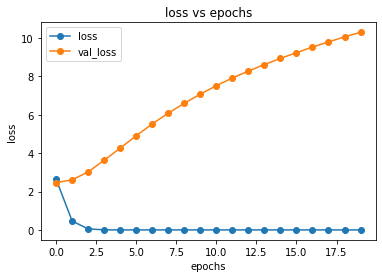

In [10]:
plt.plot(H.history['loss'], 'o-',label="loss")
plt.plot(H.history['val_loss'], 'o-', label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss vs epochs")
plt.legend();

#### Overfitting

We can see that the loss function for the training set (blue line) is steadily decreasing whereas the loss function for the testing set (orange line) reaches a minimum and then stays the same or increases a bit.
This is a sign of __overfitting__.
<br>
Overfitting occurs when the classifier starts to learn the specific peculiarities of the samples in the training set. However, by doing that it does not fit well to other data anymore. 
<br>
After the tenth epoch, the network is still learning to better fit the training set. But the featues that are being learned are specific only to the training set and are thus not useful for classifying the testing set.

トレーニングセットの損失関数（青い線）は着実に減少していますが、テストセットの損失関数（オレンジ）は最小値に達してから、同じままか少し増加してことがわかります。これは__過学習__の証拠です。
<br>
過学習は、分類器がトレーニングセット内のサンプルの特定の特性をさらに学習するが、他のデータには適合しなくなる現象です。
<br>
10回目のエポックの後、ネットワークはまだトレーニングセットによりよく適合するように学習しています。 ただし、学習される機能はトレーニングセットにのみ固有であるため、テストセットの分類には役立ちません。

Let us plot the accuracy:

精度もプロットしてみましょう。

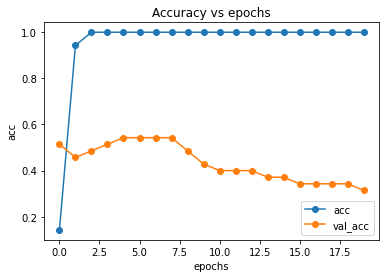

In [11]:
plt.plot(H.history['acc'], 'o-', label="acc")
plt.plot(H.history['val_acc'], 'o-', label="val_acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title("Accuracy vs epochs")
plt.legend();

We can also see that the accuracy is no longer improving after the tenth epoch.

10回目のエポック以降、精度もほとんど向上しなくなったことがわかります。

#### Preventing overfitting / 過学習の防止

One simple method to prevent overfitting is to _stop the training early_. From the curves above, it seems it would be better to stop the training after 10 epochs. 
<br>
The `fit` method provide a convenient way to do that; it accepts `callbacks`.
`callbacks` are functions that are called at specific timings during the training.
<br>
`keras` defines a callback called `EarlyStopping` that does just what we want - it can stop the training.

過学習を防ぐため、1つの簡単な方法は _訓練の中断_ です。例えば、上の曲線を見れば、10エポックの後にトレーニングを中止したら良かったと思われます。
<br>
`fit`メソッドには`コールバック`関数が使えます。（「コールバック」というのは実行中の特定のタイミングで呼び出される関数です。）
<br>
訓練を止めるには`EarlyStopping`というコールバックが使えます。

Here we define the callback for stopping early.

トレーニングを早めに中断するためのコールバックを定義します。

In [12]:
early_stopping_cb = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, verbose=1, mode='auto')

At the end of each epoch, this callback checks if the loss function for the validation set has decreased of at least `min_delta`.
<br>
If for `patience` times it has not decreased, the training is interrupted.

各エポックの終わりに、このコールバックはテストセット上の損失関数が`min_delta`以上減少したかどうかチェックします。
<br>
連続的に減少していない回数が`patience`以上になりますと、訓練は中断されます。

#### Saving best models / 最高のモデルの保存

Another useful callback is `ModelCheckpoint` that saves the model with the best performance (on the validation data) to a file.

もう1つの便利なコールバックは `ModelCheckpoint`です。これは（テストデータに対して）最高のパフォーマンスのモデルをファイルに保存します。

In [13]:
model_checkpoint_cb = ModelCheckpoint("best_network.hdf5", monitor='val_loss', verbose=1, 
                                      save_best_only=True, save_weights_only=False, mode='auto', period=1)

This callback monitors `val_loss` and saves only the best model (model structure and trained weights) in the file `best_network.hdf5`.

このコールバックは`val_loss`を監視し、その値が最低になったモデル（ネットワークの構造と重み）をファイル` best_network.hdf5`に保存します。

Then, we just have to provide the callback objects to the `fit` method.
<br>
The function `fit` expects a list of callbacks. 
Here we provide a list of two elements.

それから、コールバックオブジェクトを `fit`メソッドに渡すだけです。
<br>
`fit`はコールバックのリストを期待します。ここでは2つの要素のリストを提供します。

In [14]:
H = network.fit(X_train, y_train_one_hot, batch_size=100, epochs=20, validation_data=(X_test, y_test_one_hot),
                callbacks=[early_stopping_cb, model_checkpoint_cb], verbose=1)

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 2.8916e-06 - acc: 1.0000
Epoch 00001: val_loss improved from inf to 10.51627, saving model to best_network.hdf5
1/1 [==============================] - 0s 108ms/step - loss: 2.8916e-06 - acc: 1.0000 - val_loss: 10.5163 - val_acc: 0.3143
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 2.3535e-06 - acc: 1.0000
Epoch 00002: val_loss did not improve from 10.51627
1/1 [==============================] - 0s 23ms/step - loss: 2.3535e-06 - acc: 1.0000 - val_loss: 10.7267 - val_acc: 0.3143
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 1.9209e-06 - acc: 1.0000
Epoch 00003: val_loss did not improve from 10.51627
1/1 [==============================] - 0s 21ms/step - loss: 1.9209e-06 - acc: 1.0000 - val_loss: 10.9243 - val_acc: 0.3143
Epoch 00003: early stopping


You can see that `fit` reports saving the model and stops before completing all the epochs.

`fit`はモデルの保存を報告し、すべてのエポックを完了する前に停止することがわかります。

####  Reloading the model / 保存したモデルの再読み込み

The `ModelCheckpoint` callback saved the network with the lowest `val_loss` in the file `best_network.hdf5`.
<br>
It is possible to load the weights of that `model` with the following command.

`ModelCheckpoint`コールバックはファイル` best_network.hdf5`の最も低い `val_loss`でネットワークを保存しました。
<br>
次のコマンドでその`model`の重みをロードすることができます。

In [15]:
network.load_weights('best_network.hdf5')

Now the weights in `network` are set to the weights that were saved in `best_network.hdf5`.

これで`network`の重みは`best_network.hdf5`に保存された重みに設定されました。

It is also possible to create a new `Model` using the function `load_model` from the package `tensorflow.keras.models`.

パッケージ`tensorflow.keras.models`にある`load_model`関数を使えば新しい`Model`を作成することもできます。

In [16]:
from tensorflow.keras.models import load_model
best_network = load_model('best_network.hdf5')

After this command `best_network` is a newly created `Model` identical to the best `Model` that was created during training.

このコマンドの後、`best_network`はトレーニング中に作成された最高の`Model`と同一の`Model`です（構造も重みも同じです）。

During the training, the `ModelCheckpoint` callback saved the network.
We can also save a `Model` directly by using the `save` method.

トレーニング中、`ModelCheckpoint`コールバックはネットワークを保存しました。
`save`メソッドを使えば`Model`を直接保存することも可能です。

In [17]:
network.save('my_network.hdf5')

####  Performance of the network / ネットワークの性能

The `predict` method of a `Model` gives the predicted output for the given input.

`Model`の` predict`メソッドは与えられた入力に対する出力の予測を返します。

In [18]:
y_pred_one_hot = best_network.predict(X_test)

The network prediction is the values of the output.
<br>
Here, it is a vector of length dimension `10`.

ネットワーク予測は、出力の値です。
<br>
ここでは、長さ次元`10`のベクトルです。

In [19]:
y_pred_one_hot[0,:].shape

(10,)

We used the `softmax` activation function in the output layer of the network. The result shows it is dominated by a single value.

ネットワークの出力層で`softmax`活性化関数を使いました。予測結果を見ると、多くの場合一つの値だけが大きくなっています。

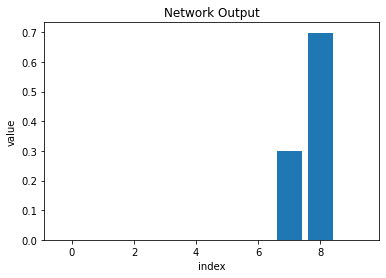

In [20]:
plt.bar(np.arange(10), y_pred_one_hot[0,:])
plt.xlabel("index")
plt.ylabel("value")
plt.title("Network Output");

If we display a few samples as an image, we can see that most of the rows are dominated by a single value.

いくつかのサンプルの予測結果を画像として表示すると、ほとんどの行では一つの値だけが大きいことがわかります。

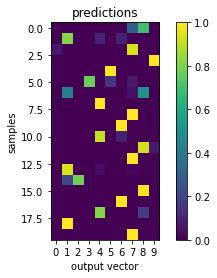

In [21]:
plt.imshow(y_pred_one_hot[:20,:])
plt.xlabel("output vector")
plt.xticks(np.arange(10))
plt.ylabel("samples")
plt.title("predictions")
cbar = plt.colorbar()

The function `argmax` from `numpy` gives the index corresponding to the maximum of a numpy array.

`numpy`の`argmax`関数は、numpy配列の最大値に対応するインデックスを返します。

In [22]:
print("index of the max:", np.argmax(y_pred_one_hot[0,:]))

index of the max: 8


By specifying the axis along which to find the maxima (here `axis=1`), it can be applied to the complete prediction block.

検索軸を指定すれば（ここでは `axis = 1`）、複数の予測結果の最大値を計算することができます。

In [23]:
y_pred = np.argmax(y_pred_one_hot, axis=1)

Now, `y_pred` contains values in `[0,9]`. These are the predicted values for the digits in the input image.

`y_pred`には0から9の値が入っています。入力画像の数字の予測です。

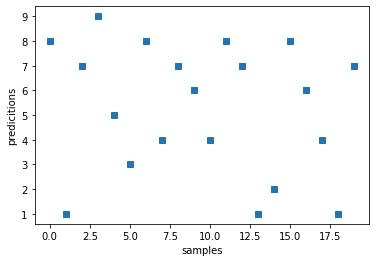

In [24]:
plt.plot(y_pred[:20], 's')
plt.xlabel("samples")
plt.ylabel("predicitions");

It is possible to use the `sklearn` functions to check the performance, like we did last week.

先週やっていたように、`sklearn`の数を使ってパフォーマンスを確認できます。

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score
CM = confusion_matrix(y_test, y_pred)
print(CM)
acc = accuracy_score(y_test, y_pred)
print(acc)

[[1 0 0 0 0 1 1 1 0 0]
 [0 2 0 0 1 0 0 0 0 0]
 [0 0 4 0 1 0 0 0 0 0]
 [0 2 0 0 0 1 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 1 0 1 0]
 [0 1 0 0 1 0 0 1 0 0]
 [0 1 0 0 0 0 0 2 3 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 1 1]]
0.3142857142857143


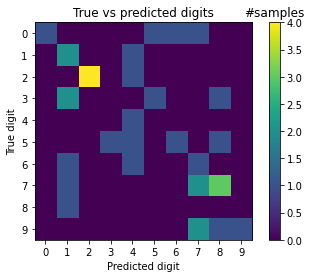

In [26]:
plt.imshow(CM)
plt.xlabel("Predicted digit")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.ylabel("True digit")
plt.title("True vs predicted digits")
cbar = plt.colorbar()
cbar.ax.set_title("#samples", rotation=0);

## Try  it yourself ! / 自分で試そう！

Since the network created here is taking GPU resources, you should first free them to create networks in other Jupyter notebooks.
<br>
One easy way to do this is by shuting down or restaring the kernel in this notebook.
<br>
Run now the menu command `Kernel`->`Restart`.

ここで作成されたニューラルネットワークはGPUリソースを使用しています。他のJupyterノートブックでネットワークを作成するためには、まずGPUリソースを解放する必要があります。
<br>
これを行う簡単な方法の1つは、このノートブックでカーネルを停止または再起動することです。
<br>
今すぐメニューコマンド`Kernel`->`Restart`を実行してください。

Then, [click here](session10-playground.ipynb) to open a sample notebook.

次に、[ここをクリックして](session10-playground.ipynb)、サンプルのノートブックを開きます。

---

#### Should you use neural networks or something else? / ニューラルネットワークを使うべきか、それとも他のものを使うべきか？

There is no easy answer to what machine learning method to use. Here are a few hints.

- For very large datasets and complex tasks (e.g. determining what is in an image), (deep) neural networks will nowadays typically work best. Although, determining which network structure to use (how many layers etc.) can be difficult.

- For smaller datasets you can achieve good results with simpler methods. Two methods which usually perform well are (nonlinear) SVM and Random Forests. Random Forests also have very little parameters so it is perhaps one of the simplest methods to try (see sklearn.ensemble.RandomForestClassifier).

- If the dataset is small, training a large neural network does not make sense (in some cases transfer learning can be used, see session 12). You can train a small neural network with a few layers, but you should also try other methods like SVM as they might work better.

- Sometimes it may be enough for you to use something even simpler, like Perceptron or Logistic Regression (for example, you might not need to use a complex method to achieve 99% accuracy if a simple one can give you 97%).

- In general, you should try comparing multiple methods, starting with simple ones, until you achieve the desired performance.


どの機械学習手法を使うべきか、簡単な答えはありません。ここではいくつかのヒントを紹介します。

- 非常に大きなデータセットや複雑なタスク（例えば、画像に何が写っているかを判断する）には、最近では、（ディープ）ニューラルネットワークが最も効果的です。しかし、どのようなネットワーク構造を使用するか（何層にするかなど）を決定するのは難しいかもしれません。

- データセットが小さい場合は、よりシンプルな手法でも良い結果が得られます。通常、良い結果が得られる2つの手法は、（非線形）SVMとランダムフォレストです。ランダムフォレストもパラメータが少ないので、使いやすい手法の1つです（sklearn.ensemble.RandomForestClassifierを参照）。

- データセットが小さい場合、大規模なニューラルネットワークを学習しても意味がありません（場合によっては転移学習が使えます、セッション12参照）。いくつかの層を持つ小さなニューラルネットワークを学習することができます。ただ、その際、SVMなどの手法の結果と比較したほうがいいです。

- 場合によっては、パーセプトロンやロジスティック回帰のようなもっと単純な方法で十分なこともあります（例えば、単純な方法で97％の精度が得られるなら、99％の精度を得るために複雑な方法を使う必要はないかもしれません）。

- 一般的には，目的の性能が得られるまで，単純なものから始めて，複数の手法を比較してみるとよいでしょう。